# Multi-Run Evaluation Analysis

Analyzes evaluation runs with **repeated trials per model** to compute means, standard deviations, and confidence intervals for accuracy, cost, and time.

## Parameters
Set `EVAL_DIR` below to point to a multirun directory with repeated runs per model.

In [16]:
# Parameters - modify this path to analyze different multirun directories
EVAL_DIR = "../multirun/2026-02-11/23-09-35"

In [17]:
import json
import urllib.request
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline

## Fetch Model Pricing

In [18]:
def fetch_litellm_pricing() -> dict:
    """Fetch model pricing from LiteLLM's GitHub repository."""
    try:
        url = "https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json"
        req = urllib.request.Request(url, headers={"User-Agent": "eval-analysis/1.0"})
        with urllib.request.urlopen(req, timeout=30) as response:
            data = json.loads(response.read().decode())

        pricing = {}
        for model_id, model_data in data.items():
            if not isinstance(model_data, dict):
                continue
            input_cost = model_data.get("input_cost_per_token", 0) or 0
            output_cost = model_data.get("output_cost_per_token", 0) or 0
            pricing[model_id] = {"prompt_price": input_cost, "completion_price": output_cost}

        print(f"Fetched pricing for {len(pricing)} models from LiteLLM")
        return pricing
    except Exception as e:
        print(f"Warning: Could not fetch LiteLLM pricing: {e}")
        return {}


def fetch_openrouter_pricing() -> dict:
    """Fetch model pricing from OpenRouter API."""
    try:
        url = "https://openrouter.ai/api/v1/models"
        req = urllib.request.Request(url, headers={"User-Agent": "eval-analysis/1.0"})
        with urllib.request.urlopen(req, timeout=30) as response:
            data = json.loads(response.read().decode())

        pricing = {}
        for model in data.get("data", []):
            model_id = model.get("id", "")
            model_pricing = model.get("pricing", {})
            prompt_price = float(model_pricing.get("prompt", "0") or "0")
            completion_price = float(model_pricing.get("completion", "0") or "0")
            pricing[model_id] = {"prompt_price": prompt_price, "completion_price": completion_price}
            short_name = model_id.split("/")[-1] if "/" in model_id else model_id
            if short_name not in pricing:
                pricing[short_name] = pricing[model_id]

        print(f"Fetched pricing for {len(data.get('data', []))} models from OpenRouter")
        return pricing
    except Exception as e:
        print(f"Warning: Could not fetch OpenRouter pricing: {e}")
        return {}


litellm_pricing = fetch_litellm_pricing()
openrouter_pricing = fetch_openrouter_pricing()

Fetched pricing for 2521 models from LiteLLM
Fetched pricing for 342 models from OpenRouter


## Load Evaluation Data (All Runs)

In [19]:
def find_model_pricing(model_id: str, provider: str, litellm_data: dict, openrouter_data: dict) -> tuple:
    """Find pricing for a model from LiteLLM or OpenRouter."""
    if provider == "groq":
        for key in [f"groq/{model_id}", f"groq/{model_id.split('/')[-1]}"]:
            if key in litellm_data:
                p = litellm_data[key]
                return p["prompt_price"], p["completion_price"]
        return None, None

    if provider == "openai" and model_id in litellm_data:
        p = litellm_data[model_id]
        return p["prompt_price"], p["completion_price"]

    for key in [model_id, model_id.split("/")[-1] if "/" in model_id else model_id]:
        if key in openrouter_data:
            p = openrouter_data[key]
            return p["prompt_price"], p["completion_price"]

    return None, None


def load_all_runs(eval_dir: str, litellm_data: dict, openrouter_data: dict) -> pd.DataFrame:
    """Load all eval_result.json files from a multirun directory."""
    eval_path = Path(eval_dir)
    results = []

    for json_file in sorted(eval_path.glob("*/eval_result.json"), key=lambda x: int(x.parent.name)):
        with open(json_file) as f:
            data = json.load(f)

        config = data.get("config_summary", {})
        metrics = data.get("metrics", {})
        cost_metrics = data.get("cost_metrics", {})

        model = config.get("llm_model", "unknown")
        provider = config.get("llm_provider", "unknown")
        display_name = model.split("/")[-1] if "/" in model else model

        input_tokens = cost_metrics.get("token_usage", {}).get("input_tokens", 0)
        output_tokens = cost_metrics.get("token_usage", {}).get("output_tokens", 0)

        # Get cost: prefer recorded, then estimate from tokens
        recorded_cost = cost_metrics.get("token_usage", {}).get("total_cost")
        estimated_cost = cost_metrics.get("estimated_cost_usd")
        cost = recorded_cost if recorded_cost and recorded_cost > 0 else estimated_cost

        if (cost is None or cost == 0) and input_tokens > 0:
            pp, cp = find_model_pricing(model, provider, litellm_data, openrouter_data)
            if pp is not None:
                cost = (input_tokens * pp) + (output_tokens * cp)

        duration_s = metrics.get("total_duration_seconds")

        results.append(
            {
                "model": model,
                "model_display": display_name,
                "provider": provider,
                "success_rate": data.get("success_rate", 0),
                "success_pct": data.get("success_rate", 0) * 100,
                "status": data.get("status", "unknown"),
                "duration_minutes": duration_s / 60 if duration_s else None,
                "cost_usd": cost if cost and cost > 0 else None,
                "input_tokens": input_tokens,
                "output_tokens": output_tokens,
                "items_requested": len(data.get("items_requested", [])),
                "items_successful": sum(1 for r in data.get("item_results", []) if r.get("status") == "success"),
                "run_dir": json_file.parent.name,
            }
        )

    return pd.DataFrame(results)


df_all = load_all_runs(EVAL_DIR, litellm_pricing, openrouter_pricing)

n_models = df_all["model_display"].nunique()
n_runs = len(df_all)
runs_per_model = df_all.groupby("model_display").size()
print(f"Loaded {n_runs} runs across {n_models} models")
print(f"Runs per model: {runs_per_model.min()}-{runs_per_model.max()}")
print(f"Cost data available: {df_all['cost_usd'].notna().sum()}/{n_runs}")

Loaded 150 runs across 15 models
Runs per model: 10-10
Cost data available: 109/150


## Aggregate Statistics Per Model

In [20]:
def aggregate_model_stats(df: pd.DataFrame) -> pd.DataFrame:
    """Compute mean, std, and 95% CI for each model."""
    records = []
    for model, group in df.groupby("model_display"):
        n = len(group)
        provider = group["provider"].iloc[0]

        acc_mean = group["success_pct"].mean()
        acc_std = group["success_pct"].std(ddof=1)
        acc_se = acc_std / np.sqrt(n)
        acc_ci = 1.96 * acc_se

        cost_vals = group["cost_usd"].dropna()
        cost_mean = cost_vals.mean() if len(cost_vals) > 0 else None
        cost_std = cost_vals.std(ddof=1) if len(cost_vals) > 1 else 0
        cost_se = cost_std / np.sqrt(len(cost_vals)) if len(cost_vals) > 0 else None
        cost_ci = 1.96 * cost_se if cost_se is not None else None

        time_vals = group["duration_minutes"].dropna()
        time_mean = time_vals.mean() if len(time_vals) > 0 else None
        time_std = time_vals.std(ddof=1) if len(time_vals) > 1 else 0
        time_se = time_std / np.sqrt(len(time_vals)) if len(time_vals) > 0 else None
        time_ci = 1.96 * time_se if time_se is not None else None

        records.append(
            {
                "model_display": model,
                "provider": provider,
                "n_runs": n,
                "acc_mean": acc_mean,
                "acc_std": acc_std,
                "acc_ci": acc_ci,
                "cost_mean": cost_mean,
                "cost_std": cost_std,
                "cost_ci": cost_ci,
                "time_mean": time_mean,
                "time_std": time_std,
                "time_ci": time_ci,
            }
        )

    return pd.DataFrame(records).sort_values("acc_mean", ascending=False).reset_index(drop=True)


df_stats = aggregate_model_stats(df_all)

# Display summary table
summary = df_stats[
    [
        "model_display",
        "provider",
        "n_runs",
        "acc_mean",
        "acc_std",
        "cost_mean",
        "cost_std",
        "time_mean",
        "time_std",
    ]
].copy()
summary.columns = [
    "Model",
    "Provider",
    "N",
    "Acc Mean %",
    "Acc Std %",
    "Cost Mean $",
    "Cost Std $",
    "Time Mean (min)",
    "Time Std (min)",
]
summary["Acc Mean %"] = summary["Acc Mean %"].map("{:.1f}".format)
summary["Acc Std %"] = summary["Acc Std %"].map("{:.1f}".format)
summary["Cost Mean $"] = summary["Cost Mean $"].map(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
summary["Cost Std $"] = summary["Cost Std $"].map(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
summary["Time Mean (min)"] = summary["Time Mean (min)"].map(lambda x: f"{x:.1f}" if pd.notna(x) else "N/A")
summary["Time Std (min)"] = summary["Time Std (min)"].map(lambda x: f"{x:.1f}" if pd.notna(x) else "N/A")
display(summary)

,Model,Provider,N,Acc Mean %,Acc Std %,Cost Mean $,Cost Std $,Time Mean (min),Time Std (min)
0,gpt-5-nano,openai,10,71.0,12.0,0.0601,0.0100,16.6,2.8
1,qwen3-30b-a3b-instruct-2507,openrouter,10,64.0,13.5,0.0510,0.0124,15.4,2.1
2,gpt-oss-20b,openrouter,10,52.0,22.5,0.0246,0.0046,19.2,3.0
3,llama-3.3-nemotron-super-49b-v1.5,openrouter,10,52.0,28.6,0.0699,0.0143,21.4,2.3
4,gpt-oss-120b,groq,10,48.0,12.3,0.1264,0.0121,14.9,1.8
5,gpt-4.1,openai,10,32.0,33.9,1.0448,0.0742,15.7,1.0
6,gpt-4.1-mini,openai,10,28.0,16.2,0.2144,0.0460,10.6,1.7
7,gpt-4.1-nano,openai,10,19.0,16.0,0.0834,0.0234,14.4,3.5
8,deepseek-chat-v3-0324,openrouter,10,16.0,27.6,0.0754,0.0204,14.4,2.4
9,llama-4-maverick,openrouter,10,0.0,0.0,N/A,0.0000,6.2,0.8


## Plot 1: Accuracy by Model (with error bars)

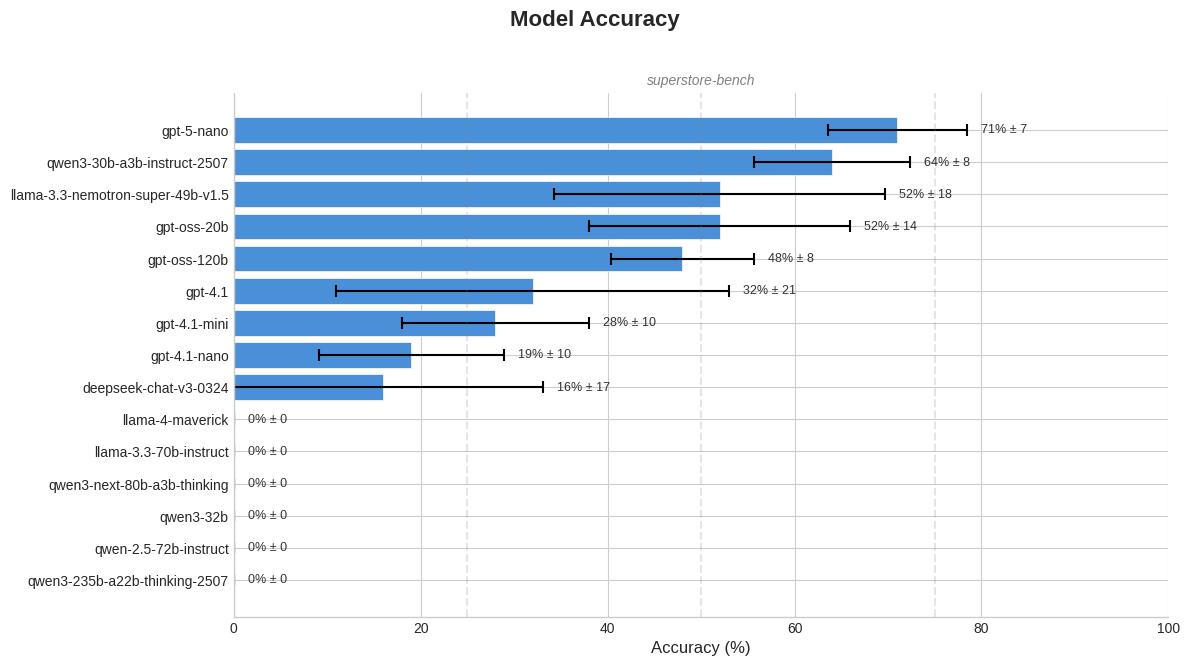

In [21]:
df_plot = df_stats.sort_values("acc_mean", ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, max(6, len(df_plot) * 0.45)))

y_pos = np.arange(len(df_plot))

ax.barh(
    y_pos,
    df_plot["acc_mean"],
    xerr=df_plot["acc_ci"],
    color="#4A90D9",
    edgecolor="white",
    linewidth=0.5,
    capsize=4,
    error_kw={"linewidth": 1.5, "capthick": 1.5, "color": "#333333"},
)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_plot["model_display"], fontsize=10)
ax.set_xlabel("Accuracy (%)", fontsize=12)
fig.suptitle("Model Accuracy", fontsize=16, fontweight="bold", y=0.98)
ax.set_title("superstore-bench", fontsize=10, style="italic", color="gray")
ax.set_xlim(0, 100)

for i, row in df_plot.iterrows():
    label = f"{row['acc_mean']:.0f}% \u00b1 {row['acc_ci']:.0f}"
    ax.text(min(row["acc_mean"] + row["acc_ci"] + 1.5, 95), i, label, va="center", fontsize=9, color="#333333")

for pct in [25, 50, 75]:
    ax.axvline(x=pct, color="gray", linestyle="--", alpha=0.2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Plot 2: Cost by Model (with error bars)

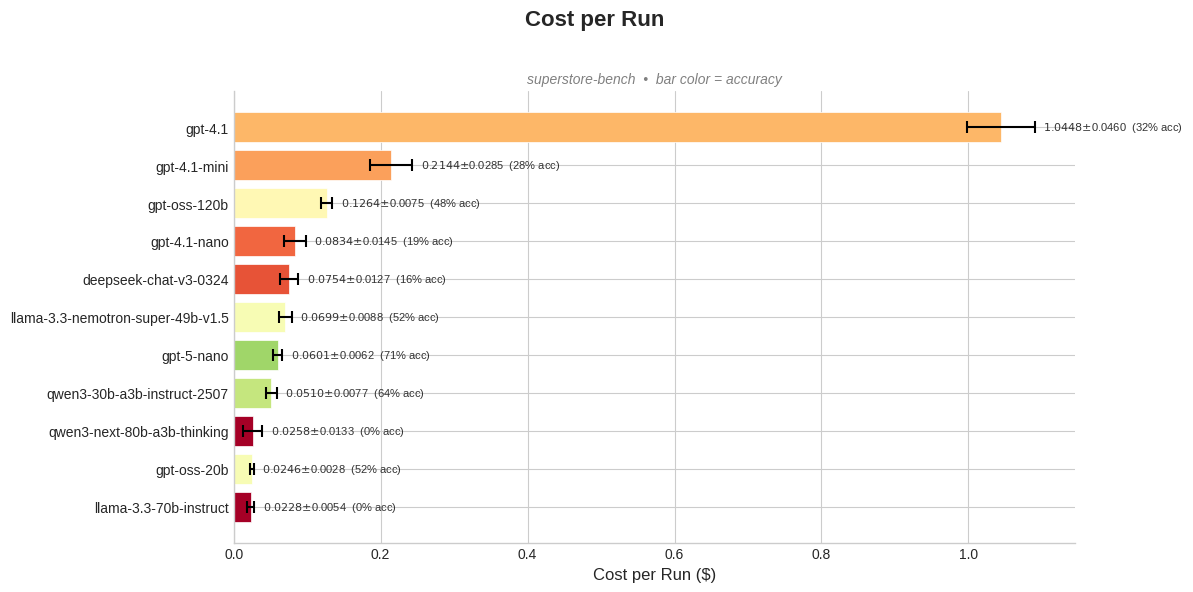

In [22]:
df_cost = df_stats[df_stats["cost_mean"].notna()].sort_values("cost_mean", ascending=True).reset_index(drop=True)

if len(df_cost) > 0:
    fig, ax = plt.subplots(figsize=(12, max(6, len(df_cost) * 0.45)))

    colors = plt.cm.RdYlGn(df_cost["acc_mean"] / 100)
    y_pos = np.arange(len(df_cost))

    ax.barh(
        y_pos,
        df_cost["cost_mean"],
        xerr=df_cost["cost_ci"].fillna(0),
        color=colors,
        edgecolor="white",
        linewidth=0.5,
        capsize=4,
        error_kw={"linewidth": 1.5, "capthick": 1.5, "color": "#333333"},
    )

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_cost["model_display"], fontsize=10)
    ax.set_xlabel("Cost per Run ($)", fontsize=12)
    fig.suptitle("Cost per Run", fontsize=16, fontweight="bold", y=0.98)
    ax.set_title("superstore-bench  \u2022  bar color = accuracy", fontsize=10, style="italic", color="gray")

    for i, row in df_cost.iterrows():
        ci_str = f" \u00b1 ${row['cost_ci']:.4f}" if pd.notna(row["cost_ci"]) else ""
        ax.text(
            row["cost_mean"] + (row["cost_ci"] if pd.notna(row["cost_ci"]) else 0) + ax.get_xlim()[1] * 0.01,
            i,
            f"${row['cost_mean']:.4f}{ci_str}  ({row['acc_mean']:.0f}% acc)",
            va="center",
            fontsize=8,
            color="#333333",
        )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No cost data available.")

## Plot 3: Execution Time by Model (with error bars)

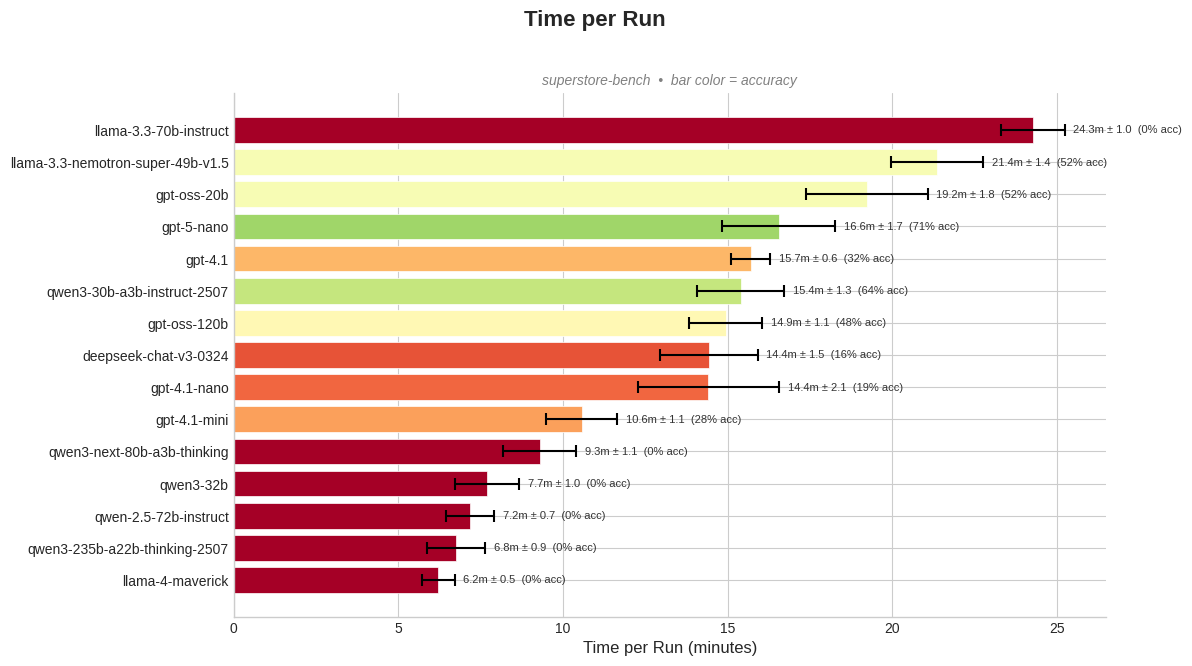

In [23]:
df_time = df_stats[df_stats["time_mean"].notna()].sort_values("time_mean", ascending=True).reset_index(drop=True)

if len(df_time) > 0:
    fig, ax = plt.subplots(figsize=(12, max(6, len(df_time) * 0.45)))

    colors = plt.cm.RdYlGn(df_time["acc_mean"] / 100)
    y_pos = np.arange(len(df_time))

    ax.barh(
        y_pos,
        df_time["time_mean"],
        xerr=df_time["time_ci"].fillna(0),
        color=colors,
        edgecolor="white",
        linewidth=0.5,
        capsize=4,
        error_kw={"linewidth": 1.5, "capthick": 1.5, "color": "#333333"},
    )

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_time["model_display"], fontsize=10)
    ax.set_xlabel("Time per Run (minutes)", fontsize=12)
    fig.suptitle("Time per Run", fontsize=16, fontweight="bold", y=0.98)
    ax.set_title("superstore-bench  \u2022  bar color = accuracy", fontsize=10, style="italic", color="gray")

    for i, row in df_time.iterrows():
        ci_str = f" \u00b1 {row['time_ci']:.1f}" if pd.notna(row["time_ci"]) else ""
        ax.text(
            row["time_mean"] + (row["time_ci"] if pd.notna(row["time_ci"]) else 0) + ax.get_xlim()[1] * 0.01,
            i,
            f"{row['time_mean']:.1f}m{ci_str}  ({row['acc_mean']:.0f}% acc)",
            va="center",
            fontsize=8,
            color="#333333",
        )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No timing data available.")

## Plot 4: Accuracy vs Cost (scatter with error bars)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


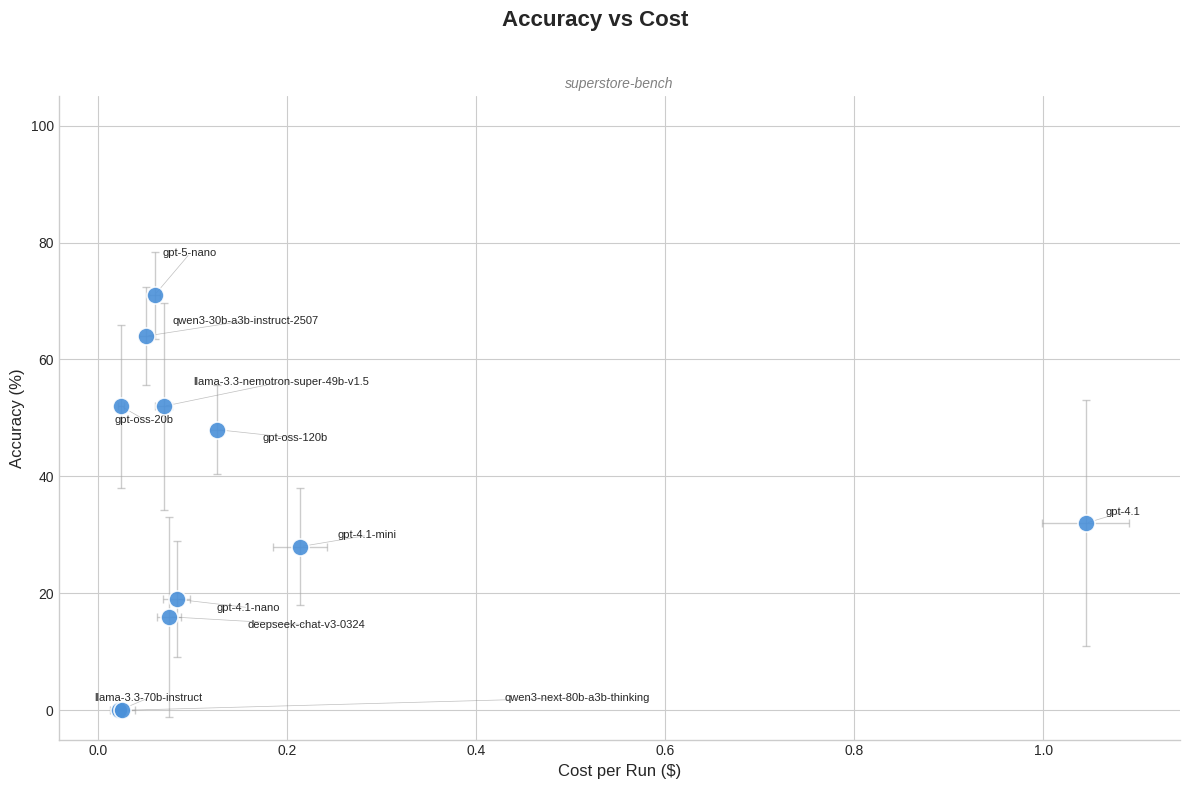

In [24]:
from adjustText import adjust_text

df_ac = df_stats[df_stats["cost_mean"].notna()].copy()

if len(df_ac) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.errorbar(
        df_ac["cost_mean"],
        df_ac["acc_mean"],
        xerr=df_ac["cost_ci"].fillna(0),
        yerr=df_ac["acc_ci"].fillna(0),
        fmt="none",
        ecolor="#AAAAAA",
        elinewidth=1,
        capsize=3,
        alpha=0.6,
        zorder=3,
    )

    ax.scatter(
        df_ac["cost_mean"],
        df_ac["acc_mean"],
        s=150,
        color="#4A90D9",
        alpha=0.9,
        edgecolors="white",
        linewidths=1.2,
        zorder=4,
    )

    texts = []
    for _, row in df_ac.iterrows():
        texts.append(ax.text(row["cost_mean"], row["acc_mean"], row["model_display"], fontsize=8))

    adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle="-", color="gray", alpha=0.5, lw=0.5),
        expand=(2.0, 2.0),
        force_text=(2.0, 3.0),
        force_static=(1.0, 1.5),
        force_pull=(0.01, 0.01),
        max_move=None,
        ensure_inside_axes=True,
        lim=500,
    )

    ax.set_xlabel("Cost per Run ($)", fontsize=12)
    ax.set_ylabel("Accuracy (%)", fontsize=12)
    fig.suptitle("Accuracy vs Cost", fontsize=16, fontweight="bold", y=0.98)
    ax.set_title("superstore-bench", fontsize=10, style="italic", color="gray")
    ax.set_ylim(-5, 105)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Plot 5: Accuracy vs Time (scatter with error bars)

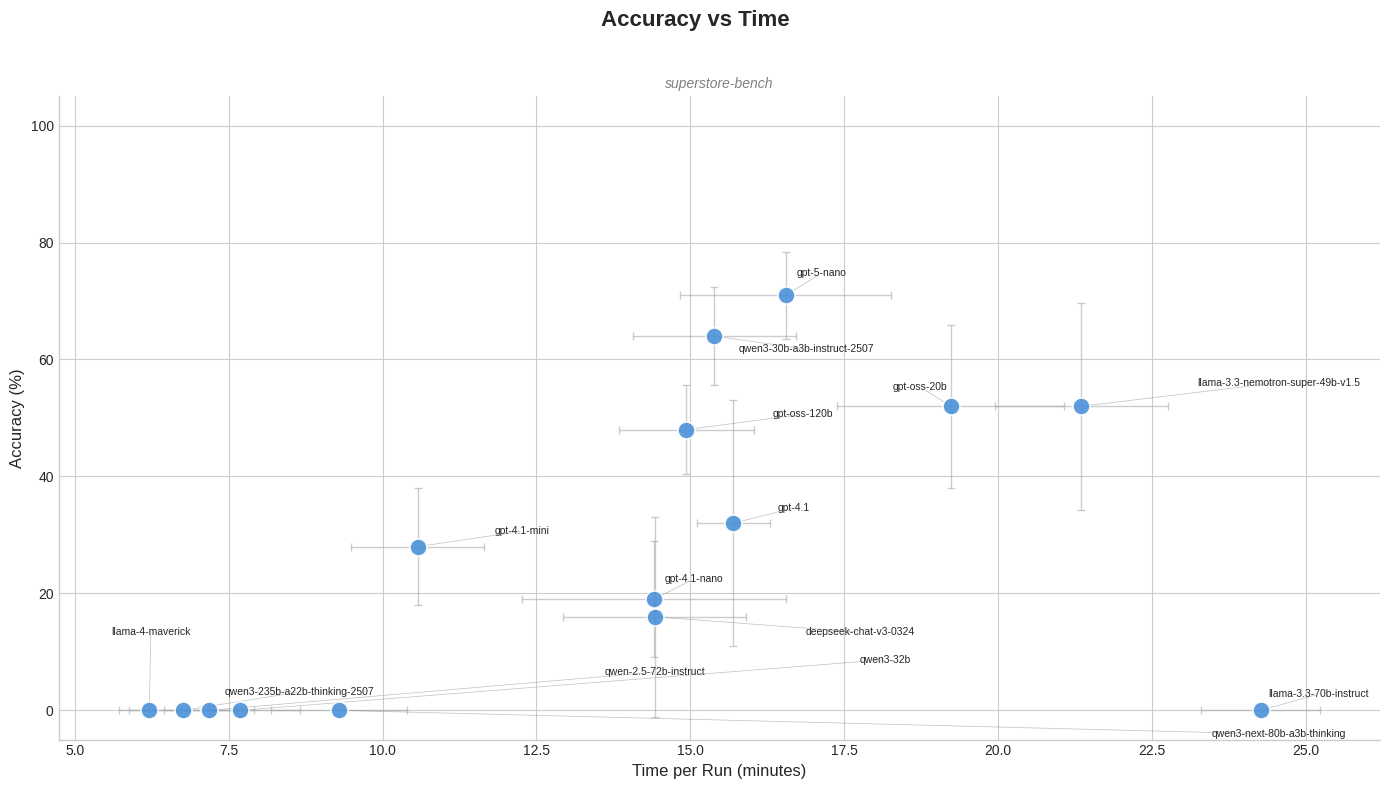

In [25]:
df_at = df_stats[df_stats["time_mean"].notna()].copy()

if len(df_at) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))

    ax.errorbar(
        df_at["time_mean"],
        df_at["acc_mean"],
        xerr=df_at["time_ci"].fillna(0),
        yerr=df_at["acc_ci"].fillna(0),
        fmt="none",
        ecolor="#AAAAAA",
        elinewidth=1,
        capsize=3,
        alpha=0.6,
        zorder=3,
    )

    ax.scatter(
        df_at["time_mean"],
        df_at["acc_mean"],
        s=150,
        color="#4A90D9",
        alpha=0.9,
        edgecolors="white",
        linewidths=1.2,
        zorder=4,
    )

    texts = []
    for _, row in df_at.iterrows():
        texts.append(ax.text(row["time_mean"], row["acc_mean"], row["model_display"], fontsize=7.5))

    adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle="-", color="gray", alpha=0.5, lw=0.5),
        expand=(2.5, 2.5),
        force_text=(3.0, 4.0),
        force_static=(1.5, 2.0),
        force_pull=(0.01, 0.01),
        max_move=None,
        ensure_inside_axes=True,
        lim=500,
    )

    ax.set_xlabel("Time per Run (minutes)", fontsize=12)
    ax.set_ylabel("Accuracy (%)", fontsize=12)
    fig.suptitle("Accuracy vs Time", fontsize=16, fontweight="bold", y=0.98)
    ax.set_title("superstore-bench", fontsize=10, style="italic", color="gray")
    ax.set_ylim(-5, 105)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Plot 6: Cost vs Time (scatter with error bars, colored by accuracy)

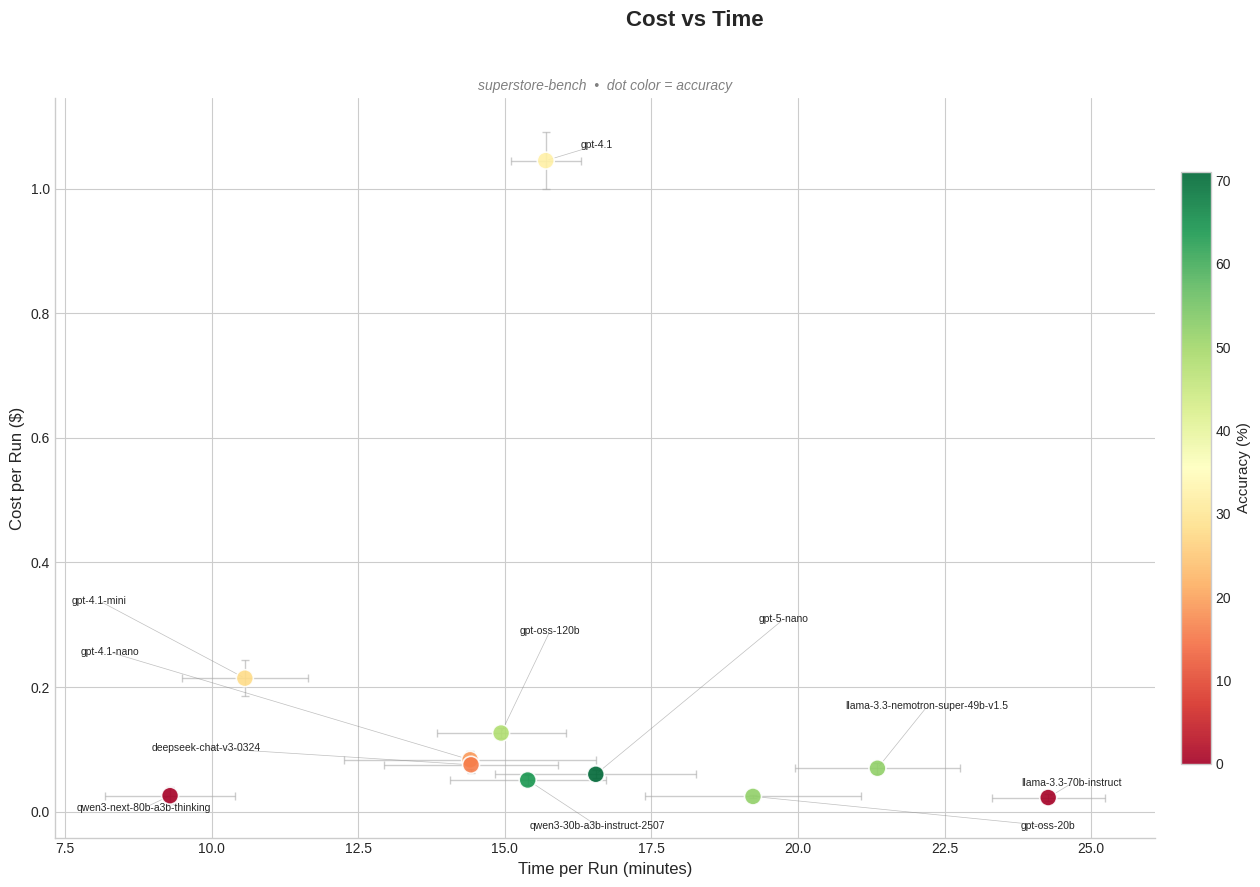

In [26]:
df_ct = df_stats[(df_stats["cost_mean"].notna()) & (df_stats["time_mean"].notna())].copy()

if len(df_ct) > 0:
    fig, ax = plt.subplots(figsize=(14, 9))

    ax.errorbar(
        df_ct["time_mean"],
        df_ct["cost_mean"],
        xerr=df_ct["time_ci"].fillna(0),
        yerr=df_ct["cost_ci"].fillna(0),
        fmt="none",
        ecolor="#AAAAAA",
        elinewidth=1,
        capsize=3,
        alpha=0.6,
        zorder=3,
    )

    scatter = ax.scatter(
        df_ct["time_mean"],
        df_ct["cost_mean"],
        s=150,
        c=df_ct["acc_mean"],
        cmap="RdYlGn",
        alpha=0.9,
        edgecolors="white",
        linewidths=1.2,
        zorder=4,
    )
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label("Accuracy (%)", fontsize=11)

    texts = []
    for _, row in df_ct.iterrows():
        texts.append(ax.text(row["time_mean"], row["cost_mean"], row["model_display"], fontsize=7.5))

    adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle="-", color="gray", alpha=0.5, lw=0.5),
        expand=(2.5, 2.5),
        force_text=(3.0, 4.0),
        force_static=(1.5, 2.0),
        force_pull=(0.005, 0.005),
        max_move=None,
        ensure_inside_axes=True,
        lim=800,
    )

    ax.set_xlabel("Time per Run (minutes)", fontsize=12)
    ax.set_ylabel("Cost per Run ($)", fontsize=12)
    fig.suptitle("Cost vs Time", fontsize=16, fontweight="bold", y=0.98)
    ax.set_title("superstore-bench  \u2022  dot color = accuracy", fontsize=10, style="italic", color="gray")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Plot 7: Per-Run Accuracy Distribution (box plot)

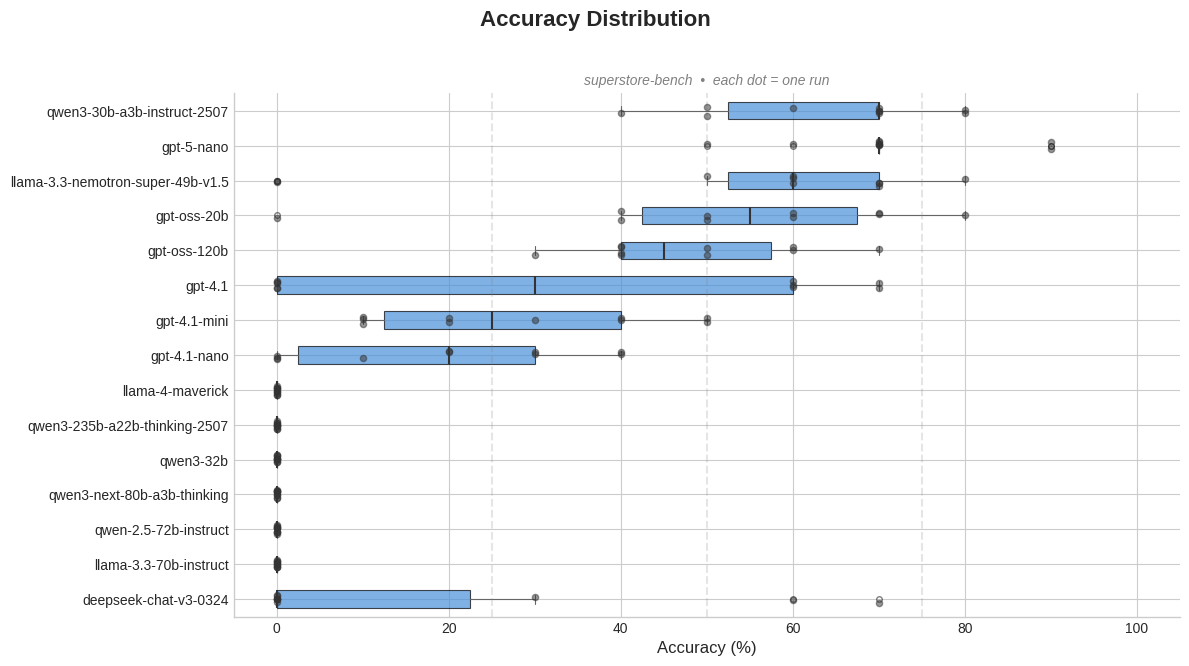

In [27]:
# Order models by median accuracy
model_order = df_all.groupby("model_display")["success_pct"].median().sort_values().index.tolist()

fig, ax = plt.subplots(figsize=(12, max(6, len(model_order) * 0.45)))

data_by_model = [df_all[df_all["model_display"] == m]["success_pct"].values for m in model_order]

bp = ax.boxplot(
    data_by_model,
    vert=False,
    patch_artist=True,
    boxprops=dict(linewidth=0.8, facecolor="#4A90D9", alpha=0.7),
    medianprops=dict(color="#333333", linewidth=1.5),
    whiskerprops=dict(linewidth=0.8, color="#666666"),
    capprops=dict(linewidth=0.8, color="#666666"),
    flierprops=dict(marker="o", markersize=4, alpha=0.5, color="#666666"),
)

for patch in bp["boxes"]:
    patch.set_facecolor("#4A90D9")
    patch.set_alpha(0.7)

# Overlay individual runs as jittered points
for i, (m, data) in enumerate(zip(model_order, data_by_model)):
    y = np.full_like(data, i + 1, dtype=float) + np.random.uniform(-0.15, 0.15, size=len(data))
    ax.scatter(data, y, alpha=0.5, s=20, color="#333333", zorder=5)

ax.set_yticklabels(model_order, fontsize=10)
ax.set_xlabel("Accuracy (%)", fontsize=12)
fig.suptitle("Accuracy Distribution", fontsize=16, fontweight="bold", y=0.98)
ax.set_title("superstore-bench  \u2022  each dot = one run", fontsize=10, style="italic", color="gray")
ax.set_xlim(-5, 105)

for pct in [25, 50, 75]:
    ax.axvline(x=pct, color="gray", linestyle="--", alpha=0.2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Plot 8: Per-Item Success Rate Heatmap

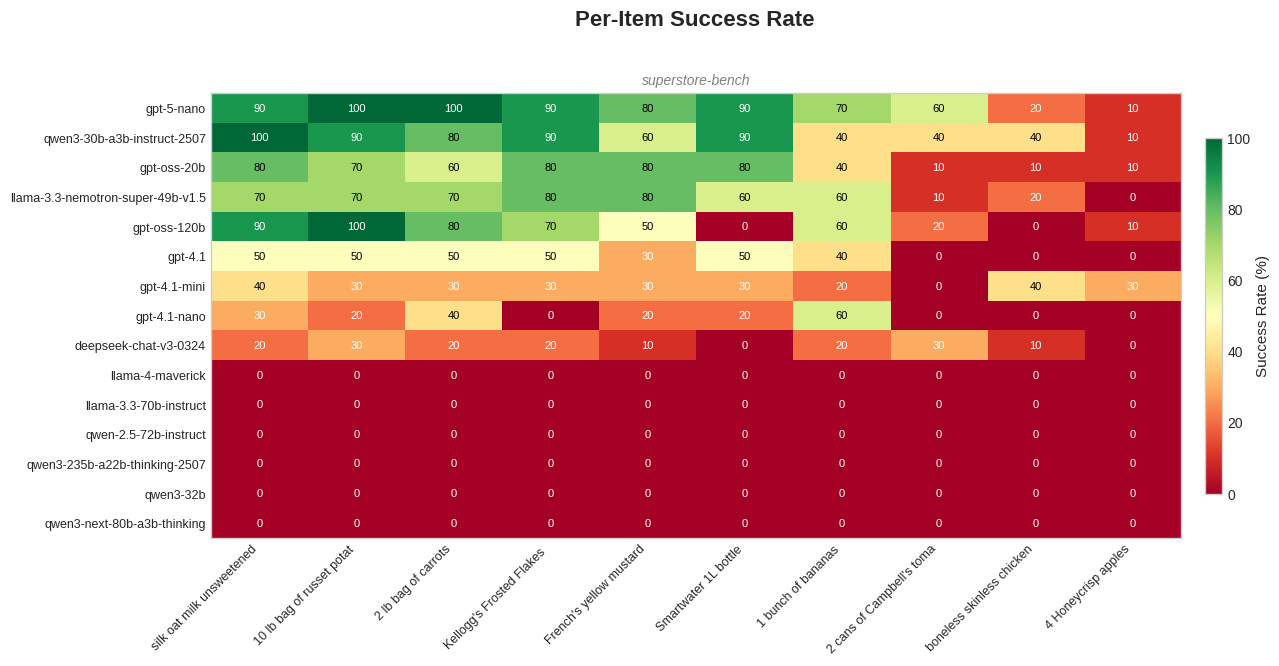

In [31]:
# Build per-item success matrix from individual runs
item_records = []
eval_path = Path(EVAL_DIR)
for json_file in sorted(eval_path.glob("*/eval_result.json"), key=lambda x: int(x.parent.name)):
    with open(json_file) as f:
        data = json.load(f)
    model = data["config_summary"]["llm_model"]
    display_name = model.split("/")[-1] if "/" in model else model
    for item_result in data.get("item_results", []):
        item_records.append(
            {
                "model_display": display_name,
                "item": item_result["item"],
                "success": 1 if item_result.get("status") == "success" else 0,
            }
        )

df_items = pd.DataFrame(item_records)

if len(df_items) > 0:
    pivot = df_items.groupby(["model_display", "item"])["success"].mean().unstack(fill_value=0) * 100

    # Order models by overall accuracy, items by overall success
    model_acc_order = pivot.mean(axis=1).sort_values(ascending=False).index
    item_order = pivot.mean(axis=0).sort_values(ascending=False).index
    pivot = pivot.loc[model_acc_order, item_order]

    fig, ax = plt.subplots(figsize=(14, max(6, len(pivot) * 0.45)))

    im = ax.imshow(pivot.values, cmap="RdYlGn", aspect="auto", vmin=0, vmax=100)

    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([c[:25] for c in pivot.columns], rotation=45, ha="right", fontsize=9)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index, fontsize=9)
    ax.grid(visible=False)

    # Annotate cells
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            val = pivot.values[i, j]
            color = "white" if val < 40 or val > 80 else "black"
            ax.text(j, i, f"{val:.0f}", ha="center", va="center", fontsize=8, color=color)

    cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label("Success Rate (%)", fontsize=11)

    fig.suptitle("Per-Item Success Rate", fontsize=16, fontweight="bold", y=0.98)
    ax.set_title("superstore-bench", fontsize=10, style="italic", color="gray")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Top Performers Summary

In [29]:
print("=" * 60)
print("TOP PERFORMERS SUMMARY")
print("=" * 60)

best = df_stats.loc[df_stats["acc_mean"].idxmax()]
print(f"\nHighest Accuracy: {best['model_display']}")
print(f"  {best['acc_mean']:.1f}% +/- {best['acc_ci']:.1f}% (n={best['n_runs']})")
if pd.notna(best["cost_mean"]):
    print(f"  Cost: ${best['cost_mean']:.4f} +/- ${best['cost_ci']:.4f}")
if pd.notna(best["time_mean"]):
    print(f"  Time: {best['time_mean']:.1f}m +/- {best['time_ci']:.1f}m")

# Most consistent (lowest accuracy std among top half)
top_half = df_stats[df_stats["acc_mean"] >= df_stats["acc_mean"].median()]
most_consistent = top_half.loc[top_half["acc_std"].idxmin()]
print(f"\nMost Consistent (top half): {most_consistent['model_display']}")
print(f"  {most_consistent['acc_mean']:.1f}% +/- {most_consistent['acc_std']:.1f}% std")

# Best cost efficiency
df_with_cost = df_stats[df_stats["cost_mean"].notna()].copy()
if len(df_with_cost) > 0:
    df_with_cost["efficiency"] = df_with_cost["acc_mean"] / df_with_cost["cost_mean"]
    best_eff = df_with_cost.loc[df_with_cost["efficiency"].idxmax()]
    print(f"\nBest Value (acc/dollar): {best_eff['model_display']}")
    print(f"  {best_eff['acc_mean']:.1f}% at ${best_eff['cost_mean']:.4f} = {best_eff['efficiency']:.0f}%/$")

# Fastest among good models
good = df_stats[df_stats["acc_mean"] >= df_stats["acc_mean"].quantile(0.5)]
good_with_time = good[good["time_mean"].notna()]
if len(good_with_time) > 0:
    fastest = good_with_time.loc[good_with_time["time_mean"].idxmin()]
    print(f"\nFastest (top 50% acc): {fastest['model_display']}")
    print(f"  {fastest['acc_mean']:.1f}% in {fastest['time_mean']:.1f}m +/- {fastest['time_ci']:.1f}m")

print("\n" + "=" * 60)

TOP PERFORMERS SUMMARY

Highest Accuracy: gpt-5-nano
  71.0% +/- 7.4% (n=10)
  Cost: $0.0601 +/- $0.0062
  Time: 16.6m +/- 1.7m

Most Consistent (top half): gpt-5-nano
  71.0% +/- 12.0% std

Best Value (acc/dollar): gpt-oss-20b
  52.0% at $0.0246 = 2111%/$

Fastest (top 50% acc): gpt-4.1-mini
  28.0% in 10.6m +/- 1.1m



## Raw Data

In [30]:
df_all[
    [
        "model_display",
        "provider",
        "success_pct",
        "duration_minutes",
        "cost_usd",
        "input_tokens",
        "output_tokens",
        "status",
    ]
]

,model_display,provider,success_pct,duration_minutes,cost_usd,input_tokens,output_tokens,status
0,gpt-4.1,openai,0.0,16.527762,1.133074,627149,12351,error
1,gpt-4.1,openai,0.0,16.158061,1.103192,617000,12161,error
2,gpt-4.1,openai,60.0,15.618761,1.018276,572966,11659,partial
3,gpt-4.1,openai,0.0,15.966746,1.078232,594496,11883,error
4,gpt-4.1,openai,70.0,14.179617,1.004580,551014,11371,partial
...,...,...,...,...,...,...,...,...
145,gpt-4.1-mini,openai,40.0,13.835403,0.269926,768111,21796,partial
146,gpt-4.1-mini,openai,10.0,11.073984,0.247795,674488,20330,partial
147,gpt-4.1-mini,openai,10.0,9.504434,0.189799,532478,16049,partial
148,gpt-4.1-mini,openai,50.0,12.044401,0.249382,694755,18239,partial
